# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 10.9KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

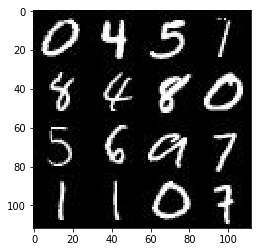

In [2]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

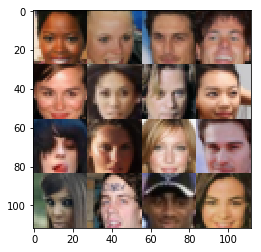

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [128]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    input_real_ph = tf.placeholder(
        tf.float32,
        [None, image_width, image_height, image_channels],
        name='input_real')
    
    input_z_ph = tf.placeholder(
        tf.float32,
        [None, z_dim],
        name='input_z')
    
    learning_rate_ph = tf.placeholder(
        tf.float32,
        [],
        name='learning_rate')

    return input_real_ph, input_z_ph, learning_rate_ph


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [198]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        
        # Convolution
        conv0 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        conv0 = tf.maximum(alpha * conv0, conv0)
        # 14x14x32 now
        
        # Convolution
        conv1 = tf.layers.conv2d(conv0, 64, 5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 7x7x64 now
        
        # Convolution
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=1, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 7x7x128 now
        
        
        # Flatten
        flat = tf.reshape(conv2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [200]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):

        # Fully Conn
        dense = tf.layers.dense(z, 7*7*64)
        
        # Reshape
        reshape = tf.reshape(dense, (-1, 7, 7, 64))
        # 7x7x64 now
        
        # Convolution
        conv1 = tf.layers.conv2d_transpose(
            reshape,
            32,
            5,
            strides=2,
            padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x32 now
        
        # Convolution
        conv2 = tf.layers.conv2d_transpose(
            conv1,
            16,
            5, strides=2,
            padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 28x28x16 now
        
        # Convolution (logits)
        conv3 = tf.layers.conv2d_transpose(
            conv2,
            out_channel_dim,
            5, strides=1,
            padding='same')
        # 28x28x3 now
        
        output = tf.tanh(conv3)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [201]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [202]:

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [203]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train.

In [204]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model
    _ , img_w, img_h, img_d = data_shape
    real_input, z_input, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    print_every = 10
    show_every = 100
    
    figsize=(5,5)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2 # converting -.5 .5 to -1 1
                steps += 1
                z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, img_d, data_image_mode)
                    
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.

Epoch 1/2... Discriminator Loss: 0.5392... Generator Loss: 1.5755
Epoch 1/2... Discriminator Loss: 0.1802... Generator Loss: 3.9310
Epoch 1/2... Discriminator Loss: 0.9564... Generator Loss: 1.4733
Epoch 1/2... Discriminator Loss: 2.3648... Generator Loss: 0.1302
Epoch 1/2... Discriminator Loss: 0.6547... Generator Loss: 1.3663
Epoch 1/2... Discriminator Loss: 0.8109... Generator Loss: 1.3864
Epoch 1/2... Discriminator Loss: 1.7603... Generator Loss: 0.2598
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 2.3465
Epoch 1/2... Discriminator Loss: 0.7903... Generator Loss: 1.3842
Epoch 1/2... Discriminator Loss: 1.3659... Generator Loss: 0.4251


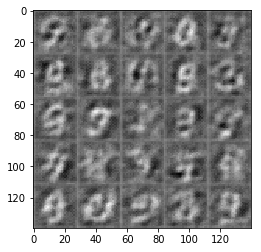

Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.5818
Epoch 1/2... Discriminator Loss: 1.0244... Generator Loss: 1.6474
Epoch 1/2... Discriminator Loss: 0.8132... Generator Loss: 1.0698
Epoch 1/2... Discriminator Loss: 0.9203... Generator Loss: 2.2544
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 1.5520
Epoch 1/2... Discriminator Loss: 0.8026... Generator Loss: 0.9216
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.9043
Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 1.5038
Epoch 1/2... Discriminator Loss: 0.7982... Generator Loss: 1.6279
Epoch 1/2... Discriminator Loss: 0.6545... Generator Loss: 1.1529


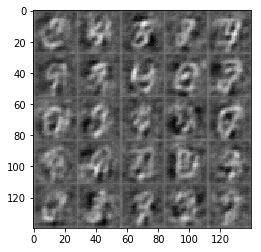

Epoch 1/2... Discriminator Loss: 0.9303... Generator Loss: 0.6568
Epoch 1/2... Discriminator Loss: 0.7470... Generator Loss: 0.9148
Epoch 1/2... Discriminator Loss: 0.5536... Generator Loss: 2.3975
Epoch 1/2... Discriminator Loss: 0.8463... Generator Loss: 2.7153
Epoch 1/2... Discriminator Loss: 0.6029... Generator Loss: 2.0434
Epoch 1/2... Discriminator Loss: 2.1607... Generator Loss: 0.2236
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.1163
Epoch 1/2... Discriminator Loss: 0.8146... Generator Loss: 0.8847
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 1.6328
Epoch 1/2... Discriminator Loss: 0.7660... Generator Loss: 1.8714


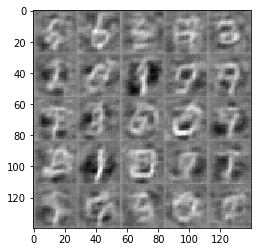

Epoch 1/2... Discriminator Loss: 0.4728... Generator Loss: 1.5022
Epoch 1/2... Discriminator Loss: 0.6690... Generator Loss: 1.2302
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 2.7060
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 2.8650
Epoch 1/2... Discriminator Loss: 1.3784... Generator Loss: 0.4064
Epoch 1/2... Discriminator Loss: 1.2930... Generator Loss: 2.7102
Epoch 1/2... Discriminator Loss: 0.6480... Generator Loss: 1.6398
Epoch 1/2... Discriminator Loss: 0.8482... Generator Loss: 1.4652
Epoch 1/2... Discriminator Loss: 1.2602... Generator Loss: 0.5149
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.4317


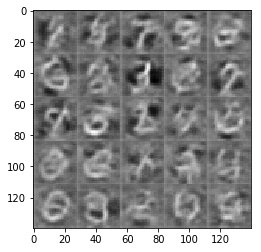

Epoch 1/2... Discriminator Loss: 1.7669... Generator Loss: 3.9061
Epoch 1/2... Discriminator Loss: 0.7467... Generator Loss: 0.9581
Epoch 1/2... Discriminator Loss: 0.7685... Generator Loss: 0.8667
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 2.0591
Epoch 1/2... Discriminator Loss: 0.6681... Generator Loss: 2.0315
Epoch 1/2... Discriminator Loss: 1.5443... Generator Loss: 3.6081
Epoch 1/2... Discriminator Loss: 0.7152... Generator Loss: 0.9740
Epoch 1/2... Discriminator Loss: 0.9998... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 0.6898... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 0.8786... Generator Loss: 0.8221


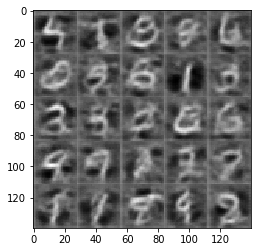

Epoch 1/2... Discriminator Loss: 1.9321... Generator Loss: 4.2940
Epoch 1/2... Discriminator Loss: 0.9016... Generator Loss: 0.8068
Epoch 1/2... Discriminator Loss: 0.7408... Generator Loss: 1.3364
Epoch 1/2... Discriminator Loss: 0.8707... Generator Loss: 0.8435
Epoch 1/2... Discriminator Loss: 1.4948... Generator Loss: 0.3894
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 0.4360
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 0.8224
Epoch 1/2... Discriminator Loss: 0.6291... Generator Loss: 1.3008
Epoch 1/2... Discriminator Loss: 2.1574... Generator Loss: 0.2025
Epoch 1/2... Discriminator Loss: 0.7255... Generator Loss: 0.9063


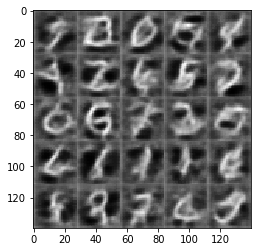

Epoch 1/2... Discriminator Loss: 0.8334... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 0.6077... Generator Loss: 1.2575
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 0.5355
Epoch 1/2... Discriminator Loss: 0.6209... Generator Loss: 2.0705
Epoch 1/2... Discriminator Loss: 8.4775... Generator Loss: 0.0010
Epoch 1/2... Discriminator Loss: 0.5990... Generator Loss: 1.3803
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 1.8556
Epoch 1/2... Discriminator Loss: 0.5473... Generator Loss: 1.4867
Epoch 1/2... Discriminator Loss: 0.5721... Generator Loss: 1.6095
Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 1.1417


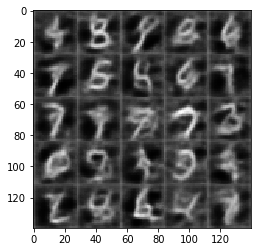

Epoch 1/2... Discriminator Loss: 0.5982... Generator Loss: 1.2035
Epoch 1/2... Discriminator Loss: 0.5381... Generator Loss: 1.4105
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.5750
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 1.3766
Epoch 1/2... Discriminator Loss: 0.7041... Generator Loss: 1.1672
Epoch 1/2... Discriminator Loss: 0.6359... Generator Loss: 1.3232
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 1.2501
Epoch 1/2... Discriminator Loss: 0.5574... Generator Loss: 1.5308
Epoch 1/2... Discriminator Loss: 0.6114... Generator Loss: 2.0002
Epoch 1/2... Discriminator Loss: 0.6981... Generator Loss: 1.0069


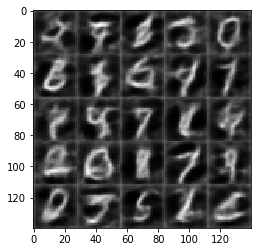

Epoch 1/2... Discriminator Loss: 0.6123... Generator Loss: 1.0681
Epoch 1/2... Discriminator Loss: 0.7347... Generator Loss: 0.8521
Epoch 1/2... Discriminator Loss: 0.9226... Generator Loss: 1.8640
Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 2.0546
Epoch 1/2... Discriminator Loss: 0.6565... Generator Loss: 1.0745
Epoch 1/2... Discriminator Loss: 0.5360... Generator Loss: 1.2839
Epoch 1/2... Discriminator Loss: 0.8092... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 0.5284... Generator Loss: 1.1733
Epoch 1/2... Discriminator Loss: 0.8165... Generator Loss: 0.8522
Epoch 1/2... Discriminator Loss: 0.5591... Generator Loss: 1.1535


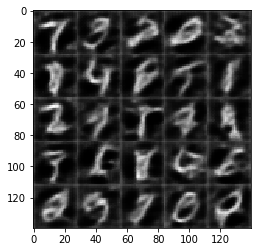

Epoch 1/2... Discriminator Loss: 4.2386... Generator Loss: 0.0252
Epoch 1/2... Discriminator Loss: 1.4564... Generator Loss: 0.3866
Epoch 1/2... Discriminator Loss: 0.6759... Generator Loss: 1.0926
Epoch 2/2... Discriminator Loss: 0.4290... Generator Loss: 1.6093
Epoch 2/2... Discriminator Loss: 0.7098... Generator Loss: 1.5086
Epoch 2/2... Discriminator Loss: 0.6874... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 0.8967
Epoch 2/2... Discriminator Loss: 0.6019... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 0.4622... Generator Loss: 1.5152
Epoch 2/2... Discriminator Loss: 0.3455... Generator Loss: 1.7582


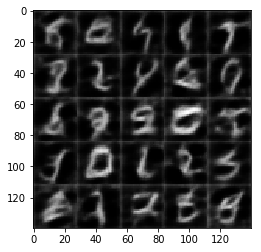

Epoch 2/2... Discriminator Loss: 3.5090... Generator Loss: 0.0798
Epoch 2/2... Discriminator Loss: 1.7088... Generator Loss: 0.3207
Epoch 2/2... Discriminator Loss: 0.9374... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 2.2690
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.6532
Epoch 2/2... Discriminator Loss: 0.7968... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 2.1403
Epoch 2/2... Discriminator Loss: 0.6291... Generator Loss: 1.2148
Epoch 2/2... Discriminator Loss: 0.5926... Generator Loss: 1.2285
Epoch 2/2... Discriminator Loss: 1.0437... Generator Loss: 0.6213


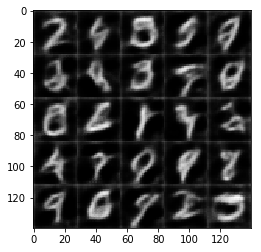

Epoch 2/2... Discriminator Loss: 0.5094... Generator Loss: 2.6216
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 1.3510
Epoch 2/2... Discriminator Loss: 0.4966... Generator Loss: 1.3633
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 1.2706
Epoch 2/2... Discriminator Loss: 0.7484... Generator Loss: 0.9070
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 1.6545
Epoch 2/2... Discriminator Loss: 0.6438... Generator Loss: 2.3354
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 1.2223
Epoch 2/2... Discriminator Loss: 0.5493... Generator Loss: 1.8825
Epoch 2/2... Discriminator Loss: 0.5691... Generator Loss: 1.1859


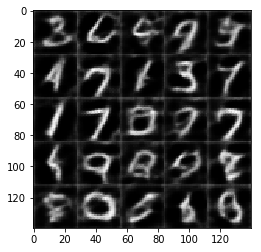

Epoch 2/2... Discriminator Loss: 0.8731... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 0.5629... Generator Loss: 1.2404
Epoch 2/2... Discriminator Loss: 0.4997... Generator Loss: 1.7564
Epoch 2/2... Discriminator Loss: 0.4311... Generator Loss: 1.5785
Epoch 2/2... Discriminator Loss: 0.4299... Generator Loss: 1.8072
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.4766
Epoch 2/2... Discriminator Loss: 0.6841... Generator Loss: 1.1988
Epoch 2/2... Discriminator Loss: 0.5829... Generator Loss: 1.2789
Epoch 2/2... Discriminator Loss: 0.4604... Generator Loss: 1.5523
Epoch 2/2... Discriminator Loss: 0.7782... Generator Loss: 2.6101


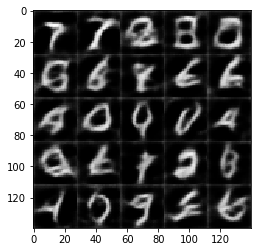

Epoch 2/2... Discriminator Loss: 1.6814... Generator Loss: 0.3338
Epoch 2/2... Discriminator Loss: 0.4030... Generator Loss: 1.7183
Epoch 2/2... Discriminator Loss: 0.4733... Generator Loss: 1.4734
Epoch 2/2... Discriminator Loss: 0.6583... Generator Loss: 0.9937
Epoch 2/2... Discriminator Loss: 0.4418... Generator Loss: 2.0108
Epoch 2/2... Discriminator Loss: 0.4561... Generator Loss: 1.8491
Epoch 2/2... Discriminator Loss: 1.6431... Generator Loss: 0.3719
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 2.2087
Epoch 2/2... Discriminator Loss: 0.5246... Generator Loss: 1.7104
Epoch 2/2... Discriminator Loss: 0.5963... Generator Loss: 1.7734


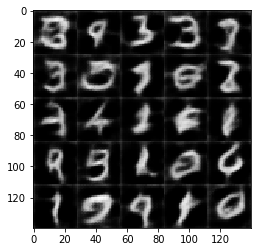

Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 2.8197
Epoch 2/2... Discriminator Loss: 0.5829... Generator Loss: 1.3988
Epoch 2/2... Discriminator Loss: 0.5763... Generator Loss: 1.5878
Epoch 2/2... Discriminator Loss: 0.6300... Generator Loss: 1.1456
Epoch 2/2... Discriminator Loss: 0.3889... Generator Loss: 1.6979
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 1.1566
Epoch 2/2... Discriminator Loss: 1.8587... Generator Loss: 0.3170
Epoch 2/2... Discriminator Loss: 0.4094... Generator Loss: 1.9247
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 0.6125... Generator Loss: 1.9105


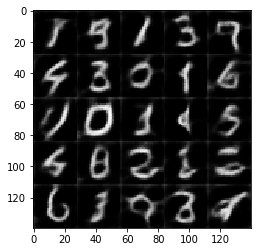

Epoch 2/2... Discriminator Loss: 0.6939... Generator Loss: 1.0155
Epoch 2/2... Discriminator Loss: 0.4362... Generator Loss: 2.5671
Epoch 2/2... Discriminator Loss: 0.5666... Generator Loss: 1.3268
Epoch 2/2... Discriminator Loss: 1.7480... Generator Loss: 4.6557
Epoch 2/2... Discriminator Loss: 0.7258... Generator Loss: 1.2369
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 0.9122
Epoch 2/2... Discriminator Loss: 0.3333... Generator Loss: 1.7583
Epoch 2/2... Discriminator Loss: 0.5188... Generator Loss: 2.3960
Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 1.1630
Epoch 2/2... Discriminator Loss: 0.6796... Generator Loss: 1.0329


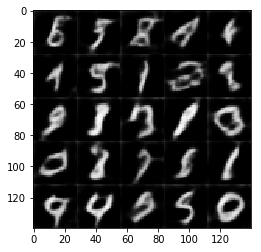

Epoch 2/2... Discriminator Loss: 0.6976... Generator Loss: 1.1833
Epoch 2/2... Discriminator Loss: 0.4048... Generator Loss: 1.6823
Epoch 2/2... Discriminator Loss: 1.2247... Generator Loss: 3.3786
Epoch 2/2... Discriminator Loss: 0.4786... Generator Loss: 2.3142
Epoch 2/2... Discriminator Loss: 0.4518... Generator Loss: 1.5146
Epoch 2/2... Discriminator Loss: 1.0485... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 0.5686... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 0.6917... Generator Loss: 1.3642
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 3.4575... Generator Loss: 6.3079


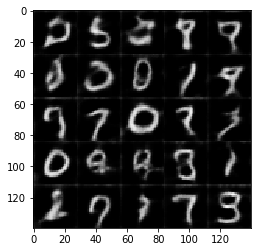

Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 0.5897
Epoch 2/2... Discriminator Loss: 0.6017... Generator Loss: 1.6385
Epoch 2/2... Discriminator Loss: 1.0961... Generator Loss: 3.1915
Epoch 2/2... Discriminator Loss: 0.6598... Generator Loss: 1.2518
Epoch 2/2... Discriminator Loss: 0.6565... Generator Loss: 3.0385
Epoch 2/2... Discriminator Loss: 0.6105... Generator Loss: 1.5498
Epoch 2/2... Discriminator Loss: 0.5939... Generator Loss: 1.3181
Epoch 2/2... Discriminator Loss: 0.5842... Generator Loss: 1.2420
Epoch 2/2... Discriminator Loss: 0.4203... Generator Loss: 1.6526
Epoch 2/2... Discriminator Loss: 0.9043... Generator Loss: 0.8293


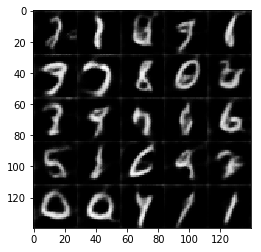

Epoch 2/2... Discriminator Loss: 0.7445... Generator Loss: 1.0686
Epoch 2/2... Discriminator Loss: 0.3601... Generator Loss: 1.8901
Epoch 2/2... Discriminator Loss: 0.5646... Generator Loss: 1.1672
Epoch 2/2... Discriminator Loss: 0.5884... Generator Loss: 1.3853
Epoch 2/2... Discriminator Loss: 1.7571... Generator Loss: 3.7317
Epoch 2/2... Discriminator Loss: 0.6726... Generator Loss: 1.4845
Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.1928


In [207]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5 # for the Adam Optimizer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
    

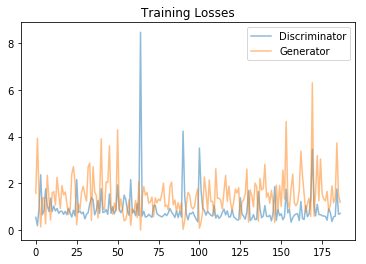

In [208]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

#### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0673... Generator Loss: 4.4602
Epoch 1/1... Discriminator Loss: 0.1572... Generator Loss: 2.7870
Epoch 1/1... Discriminator Loss: 0.1527... Generator Loss: 5.2425
Epoch 1/1... Discriminator Loss: 0.1626... Generator Loss: 4.6858
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 4.1977
Epoch 1/1... Discriminator Loss: 0.1817... Generator Loss: 5.0361
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 3.1264
Epoch 1/1... Discriminator Loss: 0.0943... Generator Loss: 5.4597
Epoch 1/1... Discriminator Loss: 5.0871... Generator Loss: 9.1013
Epoch 1/1... Discriminator Loss: 0.1312... Generator Loss: 3.8017


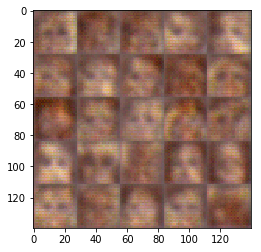

Epoch 1/1... Discriminator Loss: 0.2013... Generator Loss: 2.8699
Epoch 1/1... Discriminator Loss: 0.1787... Generator Loss: 3.3024
Epoch 1/1... Discriminator Loss: 0.1701... Generator Loss: 3.0314
Epoch 1/1... Discriminator Loss: 0.2135... Generator Loss: 2.3663
Epoch 1/1... Discriminator Loss: 0.4519... Generator Loss: 5.3629
Epoch 1/1... Discriminator Loss: 0.2948... Generator Loss: 6.2292
Epoch 1/1... Discriminator Loss: 0.3003... Generator Loss: 3.2707
Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 4.2504
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 3.3704


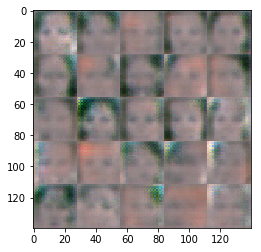

Epoch 1/1... Discriminator Loss: 0.4819... Generator Loss: 2.5612
Epoch 1/1... Discriminator Loss: 1.1693... Generator Loss: 1.1541
Epoch 1/1... Discriminator Loss: 0.3135... Generator Loss: 2.2307
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.2295
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.7521
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 1.9503
Epoch 1/1... Discriminator Loss: 1.7517... Generator Loss: 0.3664
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 2.3998
Epoch 1/1... Discriminator Loss: 0.6247... Generator Loss: 2.2187


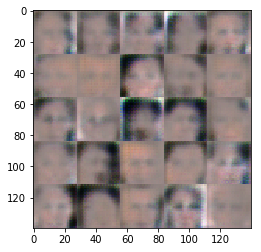

Epoch 1/1... Discriminator Loss: 0.6013... Generator Loss: 2.0133
Epoch 1/1... Discriminator Loss: 2.0910... Generator Loss: 4.3278
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 2.6456
Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 1.1811
Epoch 1/1... Discriminator Loss: 0.4317... Generator Loss: 1.6953
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.6224
Epoch 1/1... Discriminator Loss: 0.3412... Generator Loss: 2.5627
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 3.0590


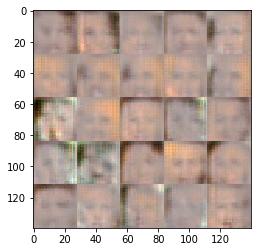

Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.5003
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.5409
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.5188
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 1.4936
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 1.5279
Epoch 1/1... Discriminator Loss: 1.6534... Generator Loss: 0.9873
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 1.2045


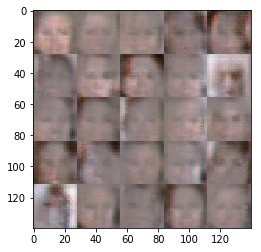

Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 2.0602
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 1.9376
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.9490
Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 1.6311
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 1.1400
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.2174
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 0.9977


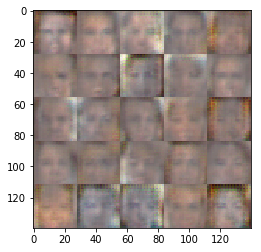

Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 0.8374... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 1.6588
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.9166
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.4601
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.8556


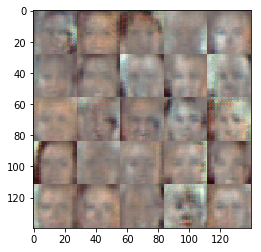

Epoch 1/1... Discriminator Loss: 0.8353... Generator Loss: 1.2619
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 1.1543
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.0779
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.3139
Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.1774
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6812


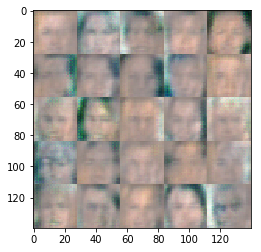

Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.1916
Epoch 1/1... Discriminator Loss: 2.3644... Generator Loss: 0.2305
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 1.8883
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.1741
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.3129


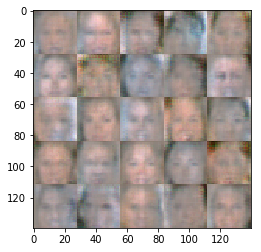

Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 1.2358


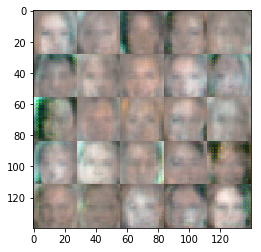

Epoch 1/1... Discriminator Loss: 1.8330... Generator Loss: 0.5382
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 1.2889
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 2.0039... Generator Loss: 0.3266
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.6696
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 1.1641
Epoch 1/1... Discriminator Loss: 1.5791... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.6535


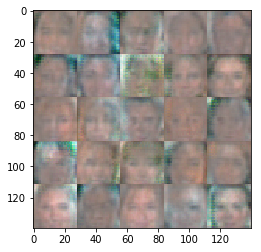

Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.4213
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.7407... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.6953
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.7712
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.7077


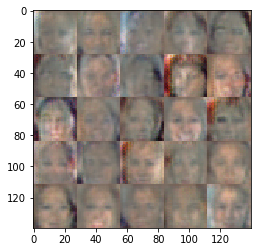

Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 0.4357
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 0.8658... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.0180... Generator Loss: 0.9201


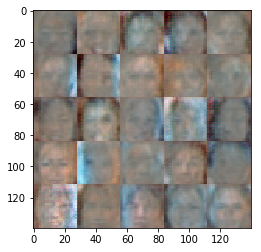

Epoch 1/1... Discriminator Loss: 1.6848... Generator Loss: 0.4499
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.3491
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.9358... Generator Loss: 1.0483
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 1.5837


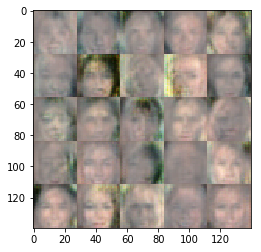

Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 0.8722... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 0.9079... Generator Loss: 1.4631
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.6359... Generator Loss: 1.8940
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.5886
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.9075


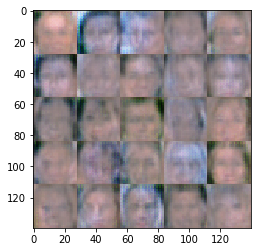

Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 1.2717
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.4062


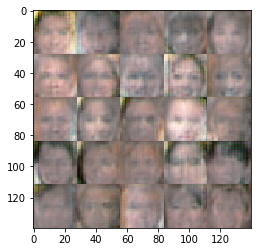

Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.4978
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 1.4373
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 1.3399
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8501


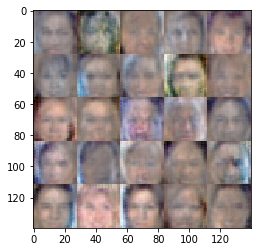

Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 1.1639
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 1.1158


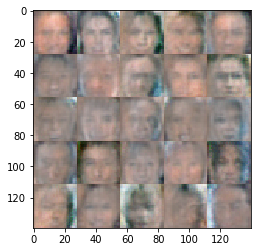

Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 1.5280
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 1.0544
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.6945


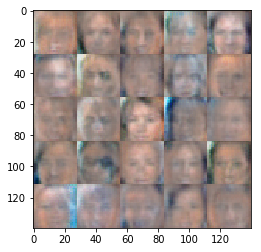

Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 1.4685
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 1.6214
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 0.9626... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.2594


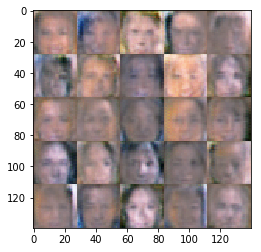

Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 1.3742
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.8350


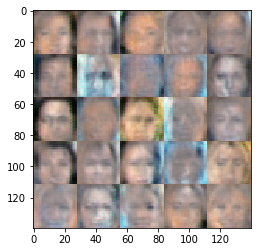

Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.4679
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 1.8451
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 1.4023


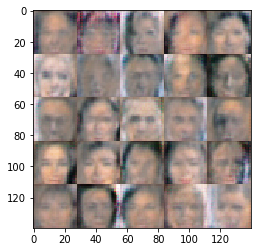

Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 1.3129
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.0811
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.6884... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.0353


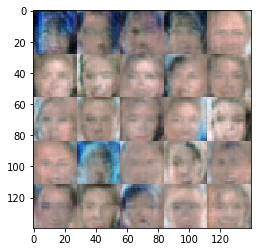

Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.5932
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.6182
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.4028
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.5732
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.4163


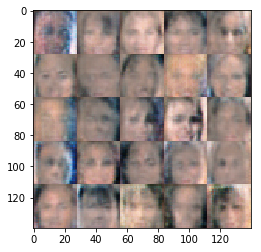

Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.0839
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 1.3053


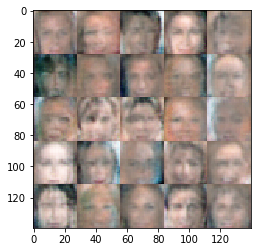

Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 1.4716
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 1.3259
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 1.0429
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.6843


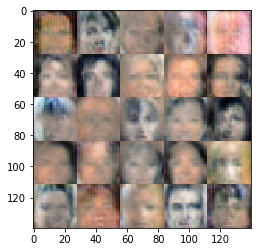

Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.4014
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.5355
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.2120
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7243


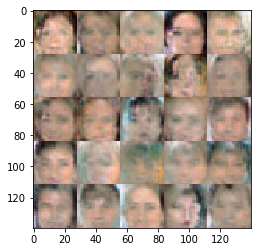

Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.6603


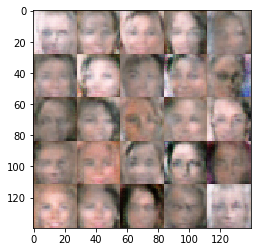

Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 1.8877
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 0.9386... Generator Loss: 1.2804
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.2755


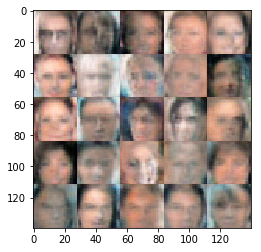

Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.2842
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 1.0253


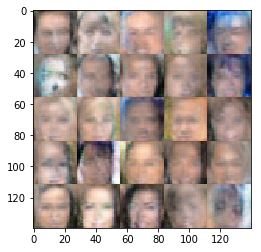

Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.4842
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.4747
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.1020
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 1.4509
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 1.5932
Epoch 1/1... Discriminator Loss: 0.8364... Generator Loss: 1.4382


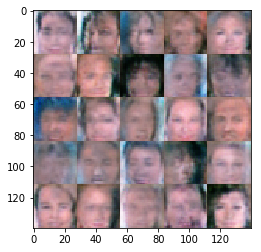

Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.2959
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.6364


In [214]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.7 # for the Adam Optimizer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

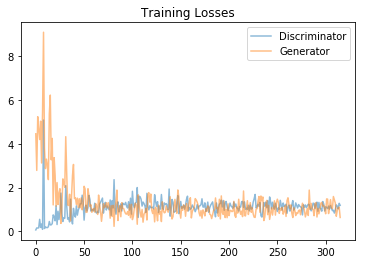

In [215]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.